In [1]:
import os

import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table, join
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
from query_gaia import *

/Users/mbedell/python/TACS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### validate parameters using Bedell+2018 solar twins:

In [3]:
if False:
    st_params = Table.read('/Users/mbedell/Documents/Papers/abundances-solartwins/data/final_parameters.csv')
    st = st_params[0:-1] # leave off the sun
    st['source_id'] = get_dr3_sources_from_simbad(st['id'])
    st_with_gaia = query_gaia_astrophysical_parameters(st)
    st_with_gaia.write('solartwins_with_gaia.csv')
    st = st_with_gaia
else:
    st = Table.read('solartwins_with_gaia.csv')

In [4]:
# suggested correction factors from Gaia archive GSPSpec documentation:
gspspec_corrected = st['logg_gspspec'] + 0.4496 - 0.0036*st['logg_gspspec'] - 0.0224*st['logg_gspspec']**2
gspmh_corrected = st['mh_gspspec'] + 0.274 - 0.1373*st['logg_gspspec'] - 0.0050*st['logg_gspspec']**2 + 0.0048*st['logg_gspspec']**3
# this doesn't do much so I don't use it in what follows

In [5]:
def fit_a_line_noerr(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, b

from scipy.odr import ODR, Model, RealData

def linear_func(B, x):
    return B[0]*x + B[1]

def fit_a_line(x,y,sigma_x,sigma_y):
    linear_model = Model(linear_func)
    data = RealData(x, y, sx=sigma_x, sy=sigma_y)
    first_guess = fit_a_line_noerr(x,y)
    odr = ODR(data, linear_model, beta0=first_guess)
    output = odr.run()
    m, b = output.beta
    m_err, b_err = output.sd_beta
    return m,b

def save_params(filename, m, b):
    import json
    with open(filename, "w") as f:
        json.dump({"m": m, "b": b}, f)

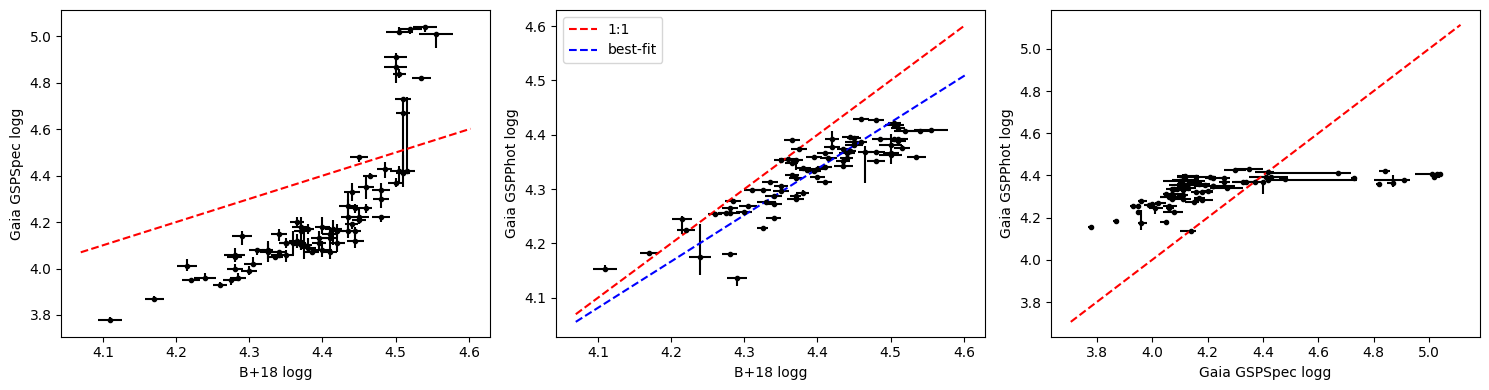

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].errorbar(st['logg'], st['logg_gspspec'], xerr=st['err_logg'], 
                 yerr=[st['logg_gspspec']-st['logg_gspspec_lower'],st['logg_gspspec_upper']-st['logg_gspspec']],
                 fmt='k.')
xl = axes[0].get_xlim()
axes[0].plot(xl, xl, 'r--', label='1:1')
axes[0].set_xlabel('B+18 logg')
axes[0].set_ylabel('Gaia GSPSpec logg')
axes[1].errorbar(st['logg'], st['logg_gspphot'], xerr=st['err_logg'], 
                 yerr=[st['logg_gspphot']-st['logg_gspphot_lower'],st['logg_gspphot_upper']-st['logg_gspphot']],
                 fmt='k.')
xl = axes[1].get_xlim()
axes[1].plot(xl, xl, 'r--', label='1:1')
avg_err = np.mean([st['logg_gspphot']-st['logg_gspphot_lower'],st['logg_gspphot_upper']-st['logg_gspphot']], axis=0)
m_logg,b_logg = fit_a_line(st['logg'], st['logg_gspphot'], st['err_logg'], avg_err)
save_params('logg_correction.json', m_logg, b_logg)
axes[1].plot(xl, m_logg*np.array(xl)+b_logg, 'b--', label='best-fit')
axes[1].set_xlabel('B+18 logg')
axes[1].set_ylabel('Gaia GSPPhot logg')
axes[1].legend()
axes[2].errorbar(st['logg_gspspec'], st['logg_gspphot'], 
             xerr=[st['logg_gspspec']-st['logg_gspspec_lower'],st['logg_gspspec_upper']-st['logg_gspspec']],
             yerr=[st['logg_gspphot']-st['logg_gspphot_lower'],st['logg_gspphot_upper']-st['logg_gspphot']],
             fmt='k.')
xl = axes[2].get_xlim()
axes[2].plot(xl, xl, 'r--')
axes[2].set_xlabel('Gaia GSPSpec logg')
axes[2].set_ylabel('Gaia GSPPhot logg')
fig.tight_layout()
fig.savefig('comparison_logg.png');

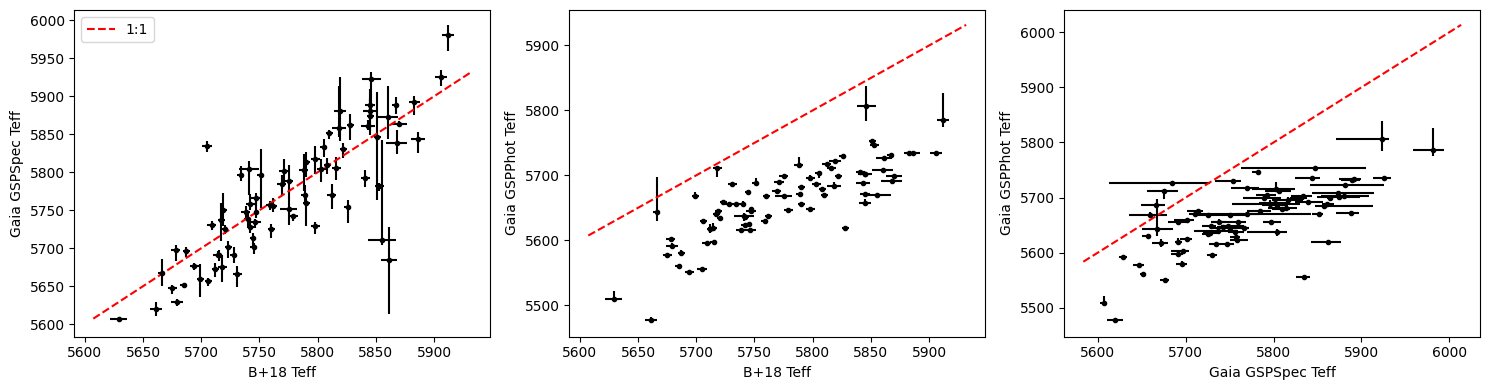

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].errorbar(st['teff'], st['teff_gspspec'], xerr=st['err_teff'], 
                 yerr=[st['teff_gspspec']-st['teff_gspspec_lower'],st['teff_gspspec_upper']-st['teff_gspspec']],
                 fmt='k.')
xl = axes[0].get_xlim()
axes[0].plot(xl, xl, 'r--', label='1:1')
axes[0].set_xlabel('B+18 Teff')
axes[0].set_ylabel('Gaia GSPSpec Teff')
axes[0].legend()
axes[1].errorbar(st['teff'], st['teff_gspphot'], xerr=st['err_teff'], 
                 yerr=[st['teff_gspphot']-st['teff_gspphot_lower'],st['teff_gspphot_upper']-st['teff_gspphot']],
                 fmt='k.')
xl = axes[1].get_xlim()
axes[1].plot(xl, xl, 'r--')
axes[1].set_xlabel('B+18 Teff')
axes[1].set_ylabel('Gaia GSPPhot Teff')
axes[2].errorbar(st['teff_gspspec'], st['teff_gspphot'], 
             xerr=[st['teff_gspspec']-st['teff_gspspec_lower'],st['teff_gspspec_upper']-st['teff_gspspec']],
             yerr=[st['teff_gspphot']-st['teff_gspphot_lower'],st['teff_gspphot_upper']-st['teff_gspphot']],
             fmt='k.')
xl = axes[2].get_xlim()
axes[2].plot(xl, xl, 'r--')
axes[2].set_xlabel('Gaia GSPSpec Teff')
axes[2].set_ylabel('Gaia GSPPhot Teff')
fig.tight_layout()
fig.savefig('comparison_teff.png');

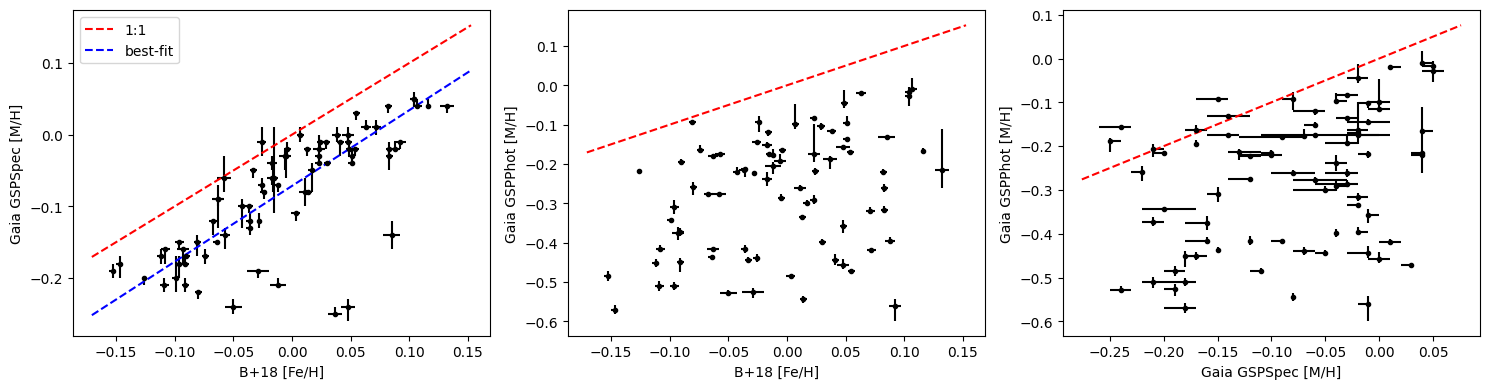

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].errorbar(st['feh'], st['mh_gspspec'], xerr=st['err_feh'], 
                 yerr=[st['mh_gspspec']-st['mh_gspspec_lower'],st['mh_gspspec_upper']-st['mh_gspspec']],
                 fmt='k.')
xl = axes[0].get_xlim()
axes[0].plot(xl, xl, 'r--', label='1:1')
avg_err = np.mean([st['mh_gspspec']-st['mh_gspspec_lower'],st['mh_gspspec_upper']-st['mh_gspspec']])
m_mh,b_mh = fit_a_line(st['feh'], st['mh_gspspec'], st['err_feh'], avg_err)
save_params('mh_correction.json', m_mh, b_mh)
axes[0].plot(xl, m_mh*np.array(xl)+b_mh, 'b--', label='best-fit')
axes[0].set_xlabel('B+18 [Fe/H]')
axes[0].set_ylabel('Gaia GSPSpec [M/H]')
axes[0].legend()
axes[1].errorbar(st['feh'], st['mh_gspphot'], xerr=st['err_feh'], 
                 yerr=[st['mh_gspphot']-st['mh_gspphot_lower'],st['mh_gspphot_upper']-st['mh_gspphot']],
                 fmt='k.')
xl = axes[1].get_xlim()
axes[1].plot(xl, xl, 'r--')
axes[1].set_xlabel('B+18 [Fe/H]')
axes[1].set_ylabel('Gaia GSPPhot [M/H]')
axes[2].errorbar(st['mh_gspspec'], st['mh_gspphot'], 
             xerr=[st['mh_gspspec']-st['mh_gspspec_lower'],st['mh_gspspec_upper']-st['mh_gspspec']],
             yerr=[st['mh_gspphot']-st['mh_gspphot_lower'],st['mh_gspphot_upper']-st['mh_gspphot']],
             fmt='k.')
xl = axes[2].get_xlim()
axes[2].plot(xl, xl, 'r--')
axes[2].set_xlabel('Gaia GSPSpec [M/H]')
axes[2].set_ylabel('Gaia GSPPhot [M/H]')
fig.tight_layout()
fig.savefig('comparison_mh.png');

From these results, I conclude that GSPPhot logg and GSPSpec [M/H] should be used with a correction factor, and GSPSpec Teff can be used as-is.

### apply to gr8stars catalog:

In [9]:
if False:
    table = Table.read('Master_table.csv')
    source_ids = table['gaiaedr3_source_id']
    table_with_gaia = query_gaia_astrophysical_parameters(table, source_id_name='gaiaedr3_source_id')
    table_with_gaia.write('gr8_with_gspspec.csv')
else:
    table_with_gaia = Table.read('gr8_with_gspspec.csv')

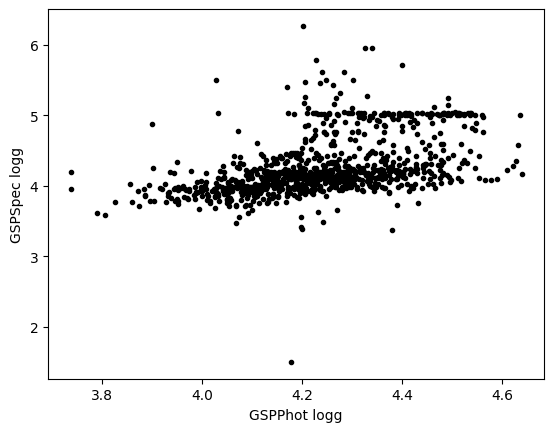

In [10]:
plt.plot(table_with_gaia['logg_gspphot'], table_with_gaia['logg_gspspec'], 'k.')
plt.xlabel('GSPPhot logg')
plt.ylabel('GSPSpec logg');

In [11]:
table_with_gaia['logg_gspphot_corrected'] = (table_with_gaia['logg_gspphot'] - b_logg) / m_logg
table_with_gaia['mh_gspspec_corrected'] = (table_with_gaia['mh_gspspec'] - b_mh) / m_mh

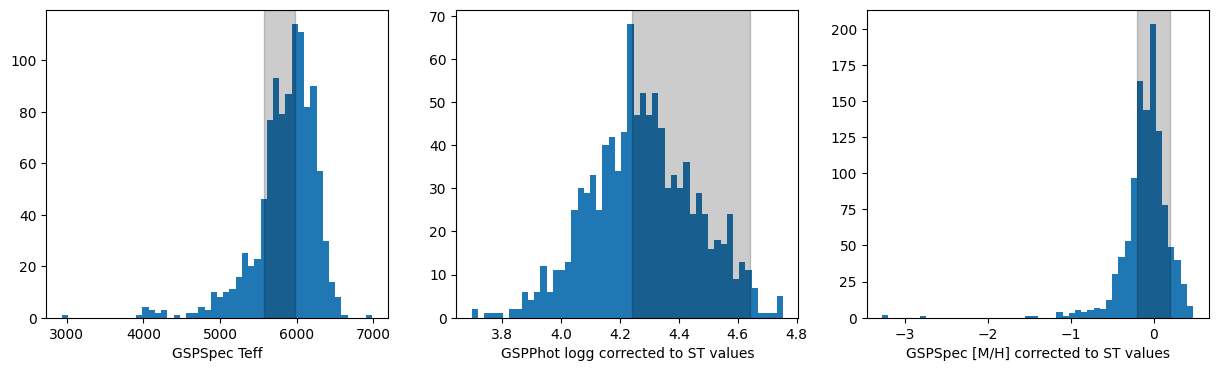

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(table_with_gaia['teff_gspspec'], bins=50)
axes[0].axvspan(*np.array([-200,200])+5778., color='k', alpha=0.2)
axes[0].set_xlabel('GSPSpec Teff')
axes[1].hist(table_with_gaia['logg_gspphot_corrected'], bins=50)
axes[1].axvspan(*np.array([-0.2,0.2])+4.44, color='k', alpha=0.2)
axes[1].set_xlabel('GSPPhot logg corrected to ST values')
axes[2].hist(table_with_gaia['mh_gspspec_corrected'], bins=50)
axes[2].axvspan(*np.array([-0.2,0.2])+0., color='k', alpha=0.2)
axes[2].set_xlabel('GSPSpec [M/H] corrected to ST values');

In [13]:
# filter out 94 objects without gspphot loggs (why??):
table_with_gaia = table_with_gaia[np.logical_not(table_with_gaia['logg_gspphot'].mask).nonzero()]

In [14]:
filters = (table_with_gaia['NIGHTS'] > 240) & (np.abs(table_with_gaia['teff_gspspec'] - 5778.) <= 200) & \
          (np.abs(table_with_gaia['logg_gspphot_corrected'] - 4.44) <= 0.2) & \
          (np.abs(table_with_gaia['mh_gspspec_corrected']) <= 0.2)
table_with_gaia[filters].write('gr8_solartwins.csv', overwrite=True)

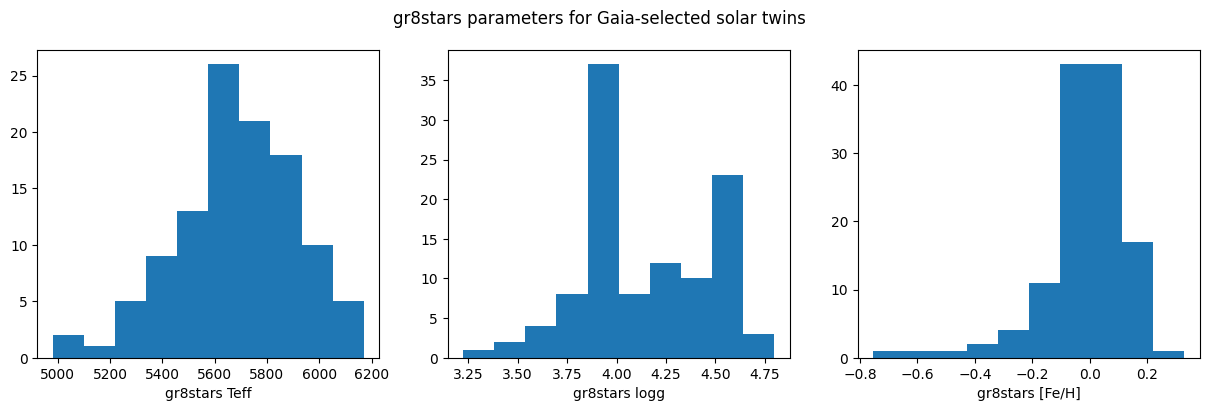

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('gr8stars parameters for Gaia-selected solar twins')
axes[0].hist(table_with_gaia[filters]['Teff(K)'])
axes[0].set_xlabel('gr8stars Teff')
axes[1].hist(table_with_gaia[filters]['logg'])
axes[1].set_xlabel('gr8stars logg')
axes[2].hist(table_with_gaia[filters]['Fe/H'])
axes[2].set_xlabel('gr8stars [Fe/H]');

In [15]:
# are there concerningly high vsini sources?
table_with_gaia[filters][table_with_gaia[filters]['vsini'] > 10]

col0,ra_j2000,dec_j2000,primary_name,gaiaedr3_source_id,hip,hd,tic,parallax,pmra,pmdec,gmag,bp_rp,radial_velocity,spectrum_harps_1d,spectrum_harps_2d,spectrum_sophie_1d,spectrum_sophie_2d,Teff(K),Teff_err(K),logg,logg_err,Fe/H,Fe/H_err,alpha,alpha_err,vmic,vmic_err,vmac,vmac_err,vsini,vsini_err,Notes,w1mpro,w1sigmpro,w2mpro,w2sigmpro,w3mpro,w3sigmpro,j_m,j_msigcom,h_m,h_msigcom,k_m,k_msigcom,Bmag,e_Bmag,Vmag,e_Vmag,Mass,Mass-err,Mass+err,Radius,Radius-err,Radius+err,Age,Age-err,Age+err,MIST logg,MIST logg-err,MIST logg+err,Density,Density-err,density+err,MIST Teff,MIST Teff-err,MIST Teff+err,logLuminosity,logLuminosity-err,logLuminosity+err,deltanu,deltanu-err,deltanu+err,numax,numax-err,numax+err,Unnamed: 75,Unnamed: 76,Unnamed: 77,ra,dec,season_length,airmass_min,airmass_mean,tyr_rise,tyr_set,eff_nights,eff_airmass_mean,eff_seeing,nb_subexp,snr_550,snr_550_texp15,sig_rv_texp15,texp_snr_250,sig_rv_osc_texp15,sig_rv_osc+gr_texp15,HZ_period_inf,HZ_period_sup,HZ_amp_inf,HZ_amp_sup,HZ_mp_min_texp15,HZ_mp_min_osc_texp15,HZ_mp_min_osc+gr_texp15,NIGHTS,FIRST_NIGHT,LAST_NIGHT,ruwe,Teff_spec,Fe/H_spec,logg_spec,vsini_spec,Teff_phot,logRHK,Teff_gspphot,logg_gspphot,source_id,teff_gspspec,logg_gspspec,mh_gspspec,alphafe_gspspec,logg_gspphot_corrected,mh_gspspec_corrected
int64,float64,float64,str26,int64,float64,str7,int64,float64,float64,float64,float64,float64,float64,str4,str4,str4,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str10,str10,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
212,154.23604,25.860716,HD89055,727103367251735040,50355.0,89055,1043986,26.721,162.804,-295.511,7.427919,0.77498,-13.99,--,--,True,True,5988.57882688571,100.0,3.73099532456128,0.378874360527538,-0.5435,0.627788892128656,0.213146455396258,0.0,50.0,0.0,6.32,0.0,300.0,0.0,Low snr,5.82,0.116,5.739,0.039,6.046,0.016,6.41,0.029,6.137,0.023,6.083,0.023,8.197,0.153,7.573,0.019,1.01822271064556,-0.0834954988898156,0.0654890819515621,1.03599564337353,-0.008948126166884,0.0093618067711234,9.52554693746503,-0.467147422023812,0.299275979051938,4.41621313976264,-0.0415880081487376,0.0295944039957314,1.29425373212742,-0.123140413308329,0.099318659398566,6050.81377632454,-79.0486750431273,80.2575637318123,0.112087118102066,-0.0194282923742031,0.0187202730842754,135.704763482431,-5.93901142645365,4.63885625581969,2882.12155431182,-5.93901142645365,4.63885625581969,--,--,--,10.282402666666668,25.860716,261,1.0014222897865512,1.0579797121986243,2025.782899440636,2026.463818576175,178.78585759631835,1.0655886337769516,0.97765625525486,1.0,260.0,260.0,0.3027,14.708710135363804,2.125249675347321,2.856322191032108,389.018580970456,838.2940859639707,0.0669608351418214,0.0864893992557228,7.885412703743669,55.36329959897876,74.40792630046096,242,2020-10-18,2020-06-15,0.9466297,5988.57882688571,-0.5435,3.73099532456128,300.0,5840,-3.980966779249183,5785.378,4.3215,727103367251735040,5948.0,4.260000228881836,-0.12999999523162842,0.09000000357627869,4.381285964738806,-0.05529494517001603
280,138.11761,49.206482,HD78899,1012870940436984064,45187.0,78899,279825533,26.247,-49.414,-177.105,7.454318,0.962216,--,--,--,True,True,5654.9502984083,129.815933561681,4.7958879763631,0.710173088619456,-0.323,0.363910376946,0.1273408883322,0.0,2.90216458685108,0.0946854693785103,4.14,0.0,47.38

In [16]:
# double-check that all the known solar twins made it through the cuts:
st_gr8 = join(st, table_with_gaia, join_type='inner', keys_left='source_id_1', keys_right='gaiaedr3_source_id')

In [17]:
nights_filter = (st_gr8['NIGHTS'] > 240)
np.isin(st_gr8[nights_filter]['source_id_1'], table_with_gaia[filters]['gaiaedr3_source_id'])

array([ True, False,  True,  True,  True,  True])

In [18]:
# check on the solar twin that didn't make the cut:
star = st_gr8[nights_filter][1]
print("Teff from B+18: {0}, Teff from Gaia: {1}".format(star['teff'], star['teff_gspspec_1']))
print("logg from B+18: {0}, logg from Gaia: {1:.2f} (corrected to {2:.2f})".format(star['logg_1'], star['logg_gspphot_1'], star['logg_gspphot_corrected']))
print("[Fe/H] from B+18: {0}, [Fe/H] from Gaia: {1:.2f} (corrected to {2:.2f})".format(star['feh'], star['mh_gspspec_1'], star['mh_gspspec_corrected']))

Teff from B+18: 5679, Teff from Gaia: 5629.0
logg from B+18: 4.17, logg from Gaia: 4.18 (corrected to 4.22)
[Fe/H] from B+18: 0.048, [Fe/H] from Gaia: -0.00 (corrected to 0.07)


Actually seems right that this didn't pass the logg cut.

#### How much should we trust the gr8stars parameters for solar twins?

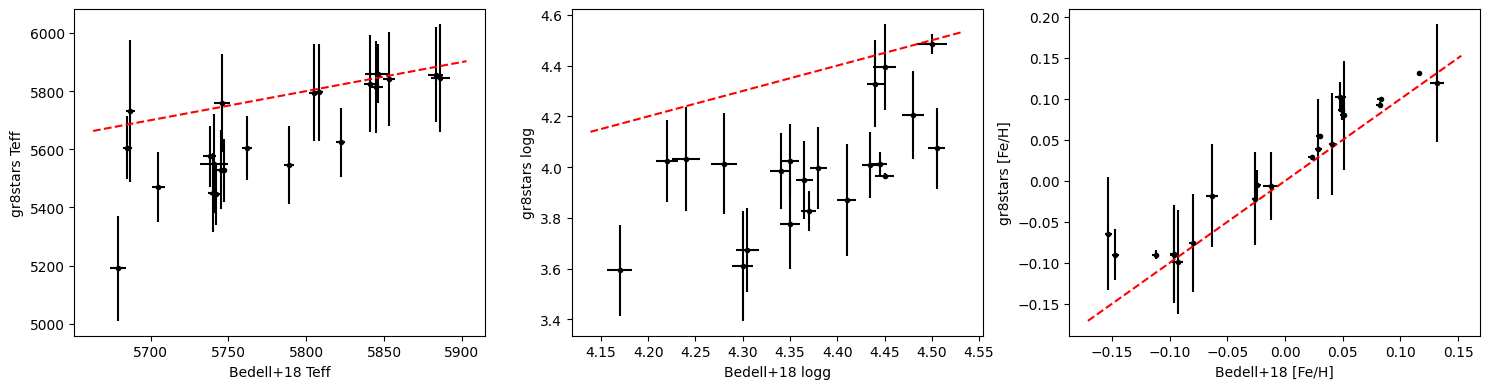

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].errorbar(st_gr8['teff'], st_gr8['Teff(K)'], 
                 xerr=st_gr8['err_teff'], yerr=st_gr8['Teff_err(K)'], fmt='k.')
xl = axes[0].get_xlim()
axes[0].plot(xl, xl, 'r--')
axes[0].set_xlabel('Bedell+18 Teff')
axes[0].set_ylabel('gr8stars Teff')
axes[1].errorbar(st_gr8['logg_1'], st_gr8['logg_2'],
             xerr=st_gr8['err_logg'], yerr=st_gr8['logg_err'], fmt='k.')
xl = axes[1].get_xlim()
axes[1].plot(xl, xl, 'r--')
axes[1].set_xlabel('Bedell+18 logg')
axes[1].set_ylabel('gr8stars logg')
axes[2].errorbar(st_gr8['feh'], st_gr8['Fe/H'],
             xerr=st_gr8['err_feh'], yerr=st_gr8['Fe/H_err'], fmt='k.')
xl = axes[2].get_xlim()
axes[2].plot(xl, xl, 'r--')
axes[2].set_xlabel('Bedell+18 [Fe/H]')
axes[2].set_ylabel('gr8stars [Fe/H]')
fig.tight_layout();

#### Checking against photometric parameters too:

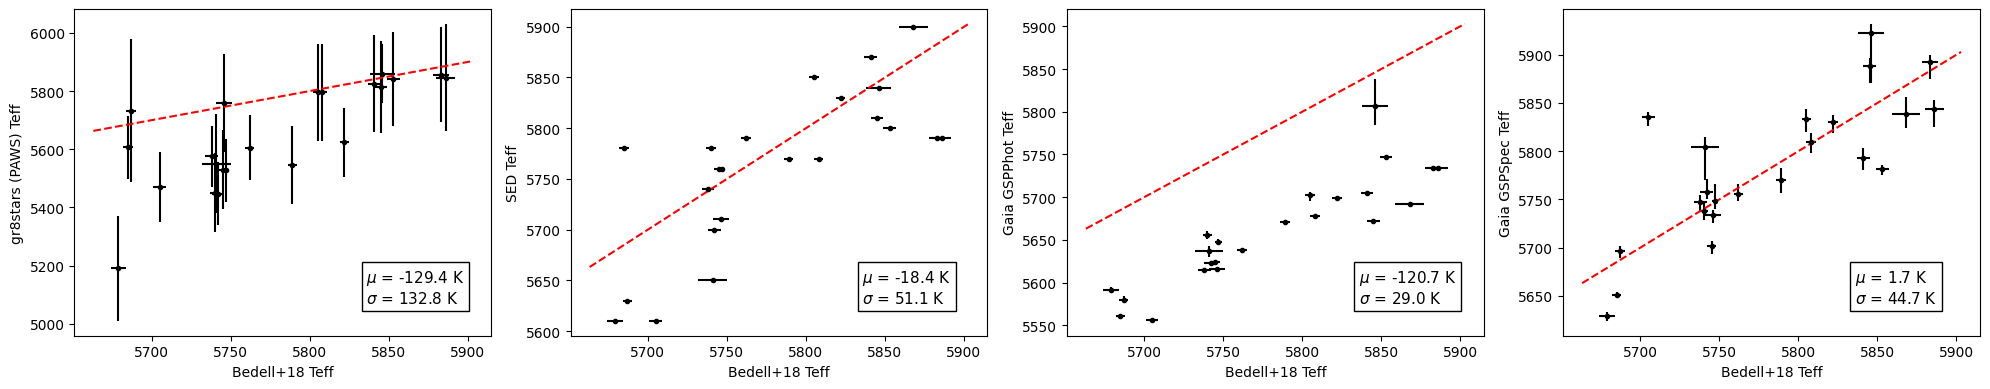

In [74]:
def write_stats(ax, x, y):
    ax.text(0.7, 0.1, r'$\mu$ = {0:.1f} K'.format(np.mean(y-x))+'\n'+r'$\sigma$ = {0:.1f} K'.format(np.std(y-x)), 
            transform=ax.transAxes, fontsize=11, bbox=dict(boxstyle='square', edgecolor='black', facecolor='white', linewidth=1))
    

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
axes[0].errorbar(st_gr8['teff'], st_gr8['Teff(K)'], xerr=st_gr8['err_teff'], yerr=st_gr8['Teff_err(K)'], fmt='k.')
xl = axes[0].get_xlim()
axes[0].plot(xl, xl, 'r--')
#axes[0].text(0.7, 0.2, r'$\mu$ = {0:.2f}'.format()+'\n'+r'$\sigma$ = {0:.2f}'.format(0), transform=axes[0].transAxes)
write_stats(axes[0], st_gr8['teff'], st_gr8['Teff(K)'])
axes[0].set_xlabel('Bedell+18 Teff')
axes[0].set_ylabel('gr8stars (PAWS) Teff')
axes[1].errorbar(st_gr8['teff'], st_gr8['Teff_phot'],
             xerr=st_gr8['err_teff'], fmt='k.')
xl = axes[1].get_xlim()
axes[1].plot(xl, xl, 'r--')
write_stats(axes[1], st_gr8['teff'],st_gr8['Teff_phot'])
axes[1].set_xlabel('Bedell+18 Teff')
axes[1].set_ylabel('SED Teff')
axes[2].errorbar(st_gr8['teff'], st_gr8['teff_gspphot'],
             xerr=st_gr8['err_teff'], 
             yerr=[st_gr8['teff_gspphot']-st_gr8['teff_gspphot_lower'],st_gr8['teff_gspphot_upper']-st_gr8['teff_gspphot']], fmt='k.')
xl = axes[2].get_xlim()
axes[2].plot(xl, xl, 'r--')
write_stats(axes[2], st_gr8['teff'],st_gr8['teff_gspphot'])
axes[2].set_xlabel('Bedell+18 Teff')
axes[2].set_ylabel('Gaia GSPPhot Teff')
axes[3].errorbar(st_gr8['teff'], st_gr8['teff_gspspec_1'],
             xerr=st_gr8['err_teff'], 
             yerr=[st_gr8['teff_gspspec_1']-st_gr8['teff_gspspec_lower'],st_gr8['teff_gspspec_upper']-st_gr8['teff_gspspec_1']], fmt='k.')
xl = axes[3].get_xlim()
axes[3].plot(xl, xl, 'r--')
write_stats(axes[3], st_gr8['teff'],st_gr8['teff_gspspec_1'])
axes[3].set_xlabel('Bedell+18 Teff')
axes[3].set_ylabel('Gaia GSPSpec Teff')
fig.tight_layout()
fig.savefig('solartwin_teff_comparison_gr8.png');

23

#### and further checking against Martos+2023:

In [25]:
martos = Table.read('martos_table_cleaned.csv')

In [34]:
st['HIP'] = [int(h.split('HIP')[1]) for h in st['id']]

In [75]:
martos_bedell = join(st, martos, join_type='inner', keys='HIP')
martos_bedell['teff', 'Teff_val', 'logg', 'log g_val', 'feh', '[Fe/H]_val']

teff,Teff_val,logg,log g_val,feh,[Fe/H]_val
int64,float64,float64,float64,float64,float64
5712,5719.0,4.395,4.36,0.104,0.109


They seem compatible enough so I'm sticking with the Bedell sample as the baseline comparison, but may go back and add in the Martos STs later.

Conclusion: gr8stars [Fe/H] may be better than Gaia GSPSpec [M/H], but I don't necessarily trust the gr8stars reported Teff or logg to the needed precision. Small sample statistics though, and see the Bensby comparison results too which agree better on Teff.